# **Steps (Transformer basic coding steps)**
1. Get tokens (input_ids, attention_mask, labels) from pre-trained model's tokenizer. You use a pre-trained tokenizer (like BERT’s) to convert raw text into tokens.

```
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

```
2. Convert these tokens into a tensor dataset. Combine input_ids, attention_mask, and labels into a TensorDataset.



```
from torch.utils.data import TensorDataset
dataset = TensorDataset(tokens["input_ids"], tokens["attention_mask"], torch.tensor(labels))

```
3. Load the tensor dataset using DataLoader. This allows batching and shuffling.


```
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

```
4. Call the pre-trained model. You load the pre-trained Transformer model and fine-tune it.


```
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

```










5. Wrap in a class (if using PyTorch MLP-style)

  This step is optional but helpful if you want to customize or mimic the traditional PyTorch training structure.

  If you're not modifying the architecture (just fine-tuning), you can use the prebuilt Hugging Face model directly.

6. Select optimizer, loss function

```
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

```
7. Train the model


```
model.train()
for batch in train_loader:
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask)
    loss = criterion(outputs.logits, labels)
    loss.backward()
    optimizer.step()

```
8. Evaluate the model. After training, switch to model.eval() and turn off gradients


```
model.eval()
with torch.no_grad():
    for batch in val_loader:
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

```
9. Test using a user-defined function. You can define a predict(text) function that tokenizes and runs through model.eval().









🟨 Optional: Hugging Face’s Trainer skips manual loops
You don’t have to write your own training loop unless you want control. Hugging Face provides:


```
from transformers import Trainer, TrainingArguments

```

So basic tranformer's code working is
1. Get tokens (input_ids, attention_mask, labels) from pre trained model
2. Convert these tokens into tensor dataset
3. Load the tensor dataset using DataLoader
4. Call the pretrained model
5. write the basic MLP work flow like we did in spam classification using BERT, in a class
6. Then call this class, select optimizer, loss function
7. train the model (model.train)
8. Evaluate the model
9. Test using some user defined function



| Model Type              | Same Steps?   | Key Differences                                                               |
| ----------------------- | ------------- | ----------------------------------------------------------------------------- |
| **BERT**                | ✅ Yes         | Input: `input_ids`, `attention_mask`, often used for classification           |
| **GPT-2**               | ⚠️ Not always | No `attention_mask` sometimes, used for **text generation**; uses causal mask |
| **T5 / BART**           | ⚠️ Partly     | Have **encoder-decoder**, used for **translation/summarization**              |
| **RoBERTa, DistilBERT** | ✅ Yes         | Same as BERT, just lighter or trained differently                             |


# Problem Statement: **Social Media Monitoring for COVID-19 Insights using BERT**

### A company is launching a social media monitoring system to identify tweets related to COVID-19, aiming to track trends, misinformation, and public sentiment. Your task is to fine-tune a pre-trained BERT model using PyTorch to classify whether a given tweet is about COVID-19 or not.

**References:**

1. **Attention is All you Need:** [Click Here](https://arxiv.org/abs/1706.03762)

2. **BERT:** [Click Here](https://arxiv.org/abs/1810.04805)





---



Imports and CUDA

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm.notebook import tqdm
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Step1:** Dataset Overview

* We use **covid_twitter_dataset_codebasics_DL** dataset which has 5287 rows.
* Columns: ID, text and target
* The feature column (text) contains the tweet content, and the target column (target) contains the binary labels indicating whether a tweet is COVID-19-related (**1**) or not (**0**).


In [ ]:
data = pd.read_csv('/content/covid_twitter_dataset_codebasics_DL.csv')
data.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5287 non-null   object
 1   text    5287 non-null   object
 2   target  5287 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ KB




---



**Step2:** Split the dataset

* Train:Test :: 70:30



---



In [ ]:
data.target.value_counts()

,count
target,
0,2746
1,2541


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data.text, data.target, test_size=0.3, random_state=42)
train_X.head()

,text
3846,Update Total cases 3 017 766 12 879 Current ca...
3257,so turns out my cat hasn t been home since lat...
2932,Wait what Ramadan goes on for weeks Nobody men...
3139,I really love watching Man v Food vs
1669,MercyOfAllah There is flexibility within the r...


In [ ]:
train_Y.head()

,target
3846,1
3257,0
2932,0
3139,0
1669,0


In [ ]:
train_Y.value_counts()

,count
target,
0,1932
1,1768


In [ ]:
test_Y.value_counts()

,count
target,
0,814
1,773


1. Split the data set
2. call the tokenizer
3. create tokenizer function


```
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  def tokenize_function(text, labels):

      encodings = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors = 'pt')

      return encodings['input_ids'],encodings['attention_mask'], torch.tensor(labels, dtype=torch.float)
```


4. Create dataset from the above


```
  train_input_ids,train_attention_mask, train_labels = tokenize_function(X_train.values.tolist(), y_train.values.tolist())
  
  val_input_ids,val_attention_mask, val_labels = tokenize_function(X_test.values.tolist(), y_test.values.tolist())

  train_dataset = torch.utils.data.TensorDataset
  (train_input_ids, train_attention_mask, train_labels)

  val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, val_labels)
```


5. Modelling

  

```
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

bert = BertModel.from_pretrained('bert-base-uncased')
bert.config.hidden_size

class SentimentClassifier(nn.Module):
def __init__(self):
  super().__init__()
  self.bert = BertModel.from_pretrained('bert-base-uncased')

  for param in self.bert.parameters():

    param.requires_grad = False

  self.classifier = nn.Sequential(

      nn.Linear(self.bert.config.hidden_size, 256),

      nn.ReLU(),

      nn.Dropout(0.3),

      nn.Linear(256, 1),

      nn.Sigmoid()
  )

def forward(self, input_ids, attention_mask):

  outputs = self.bert(input_ids=input_ids,
  
  attention_mask=attention_mask)
  
  sentence_embedding = outputs.last_hidden_state[:,0,:]
  
  return self.classifier(sentence_embedding)

```



**Step3:** Tokenization

* The AutoTokenizer from the Hugging Face library is used to load the pre-trained BERT tokenizer (bert-base-cased).


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Get tokens from tokenizer

In [ ]:
train_tokens = tokenizer(list(train_X), padding = True, truncation=True)
test_tokens = tokenizer(list(test_X), padding = True, truncation=True)

In [ ]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(train_tokens['input_ids'][0])
print(tokenizer.decode(train_tokens['input_ids'][0]))

[101, 3725, 9216, 8653, 2740, 124, 5187, 1559, 5465, 1545, 1367, 5966, 1580, 9493, 2740, 122, 5539, 1571, 26516, 4859, 1545, 4735, 1116, 21606, 5117, 1477, 3993, 1604, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] Update Total cases 3 017 766 12 879 Current cases 1 915 580 856 Deaths 207 722 468 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]




---



**Step4**: Create a dataset class
* Implement a custom TokenData class inheriting from torch.utils.data.Dataset.
* Use the train argument to toggle between training (train_tokens, train_Y) and testing datasets (test_tokens, test_Y).
* Define __len__ to return the dataset length and __getitem__ to provide tokenized inputs (input_ids, attention_mask) and labels (labels) as tensors.
* Ensure the class works correctly by retrieving a sample and verifying the output format.

In [ ]:
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = train_X
            self.tokens = train_tokens
            self.labels = list(train_Y)
        else:
            self.text_data = test_X
            self.tokens = test_tokens
            self.labels = list(test_Y)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample



---



**Step5**: Create Dataloaders

* Initialize the `TokenData` class to create train_dataset and test_dataset objects for training and testing datasets.
* Set `batch_size=30` and enable shuffling for the training dataset to improve model generalization.
* Verify that train_loader and test_loader correctly return batches of tokenized inputs and labels.

In [ ]:
batch_size = 30
# Pass True to the train parameter for the training dataset
train_dataset = TokenData(train=True)
# Pass False (or rely on the default) for the test dataset
test_dataset = TokenData(train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



---



**Step6:** Define Model
*  Use `BertForSequenceClassification` with `bert-base-cased` to load a pre-trained BERT model for sequence classification tasks.
* Use `AdamW` optimizer with a learning rate of `1e-5` to fine-tune the model parameters. This optimizer is well-suited for transformer-based models.
* Use `CrossEntropyLoss` to compute the loss for multi-class classification (as the dataset contains two classes).

In [ ]:
bert_model =  BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
optimizer = optim.AdamW(bert_model.parameters(), lr=1e-05)
loss_fn = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




---



* num_eochs = 3
* Use bert_model.to(device) to move the model to a GPU if available, or keep it on the CPU. This ensures efficient computation, especially for large datasets or models like BERT.

In [ ]:
num_epochs = 3
bert_model.to(device) # Transfer model to GPU if available

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e



---



**Step7:** Model Training

In [ ]:
for epoch in range(num_epochs):
    bert_model.train()
    total_train_loss = 0.0  # Initialize total loss for each epoch

    for i, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Set gradients to zero
        optimizer.zero_grad()

        # Pass data to the model
        outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Get logits and calculate the loss
        pred = outputs.logits
        loss = loss_fn(pred, batch['labels'])

        # Backpropagation
        loss.backward()

        # Optimizing model parameters
        optimizer.step()

        # Accumulate the loss for the epoch
        total_train_loss += loss.item()

    # Calculate and log the average loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}")


Epoch 1/3 - Training Loss: 0.4742
Epoch 2/3 - Training Loss: 0.2177
Epoch 3/3 - Training Loss: 0.1283




---



**Step8:** Model Evaluation

In [ ]:
# Set model to evaluation mode
bert_model.eval()

# Variables for tracking accuracy and loss
correct = 0
total = 0
total_test_loss = 0.0
all_preds = []
all_labels = []

# Disable gradient computation during testing
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Get logits
        logits = outputs.logits

        # Calculate loss
        loss = loss_fn(logits, batch['labels'])
        total_test_loss += loss.item()

        # Get predictions
        preds = logits.argmax(dim=1)

        # Update the correct count and total number of samples
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Calculate the average test loss
avg_test_loss = total_test_loss / len(test_loader)

# Calculate overall accuracy
accuracy = 100 * correct / total

# Print confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Print overall results
print(f"Test Set - Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Confusion Matrix:
[[748  66]
 [101 672]]
Test Set - Loss: 0.2906, Accuracy: 89.48%


**BONUS**: Visualize the Confusion Matrix

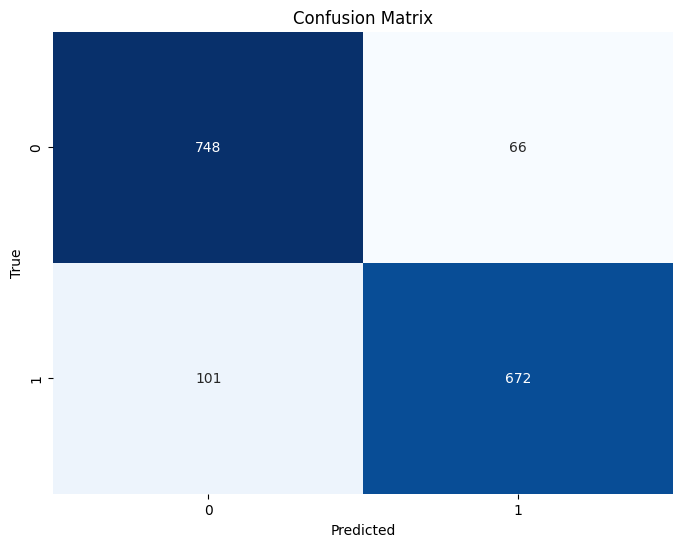

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



---



**Step9**: Inference with new Tweets

* Run this inference code to predict the output for test_tweets

In [ ]:
# Test tweets
test_tweets = [
    "The number of COVID-19 cases has increased in the past week.",
    "Just watched an amazing sunset at the beach!",
    "New vaccination centers are opening up to combat the spread of coronavirus.",
    "A virus has impacted the global ecosystem a lot",
    "India lost the match againt Australia at Adelaide"
]

# Predict function for a single tweet
def predict_tweet(tweet_text):
    # Tokenize
    tokens = tokenizer(tweet_text, padding=True, truncation=True, return_tensors='pt')
    tokens = {k: v.to(device) for k, v in tokens.items()}

    # Predict
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(**tokens)
        probs = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1)

    return {
        'text': tweet_text,
        'is_covid': bool(prediction.item()),
        'confidence': probs[0][prediction[0]].item() * 100
    }

# Make predictions for test tweets
print("Sample Tweet Predictions:\n")
for tweet in test_tweets:
    result = predict_tweet(tweet)
    print(f"Tweet: {result['text']}")
    print(f"Prediction: {'COVID-related' if result['is_covid'] else 'Not COVID-related'}")
    print(f"Confidence: {result['confidence']:.2f}%")
    print("-" * 50 + "\n")

Sample Tweet Predictions:

Tweet: The number of COVID-19 cases has increased in the past week.
Prediction: COVID-related
Confidence: 98.26%
--------------------------------------------------

Tweet: Just watched an amazing sunset at the beach!
Prediction: Not COVID-related
Confidence: 91.99%
--------------------------------------------------

Tweet: New vaccination centers are opening up to combat the spread of coronavirus.
Prediction: COVID-related
Confidence: 96.46%
--------------------------------------------------

Tweet: A virus has impacted the global ecosystem a lot
Prediction: COVID-related
Confidence: 98.13%
--------------------------------------------------

Tweet: India lost the match againt Australia at Adelaide
Prediction: Not COVID-related
Confidence: 71.89%
--------------------------------------------------

